# Predictive maintenance of machines

The goal is to create an interpretable classification model that can predict the turbine failure. Specifically, whether the turbine will experience a component failure in the 24 hours following the given telemetry and error reading. Extreme gradient boosting algorithm is used and trained model has classification accuracy of 99.96 %. Also, the notebook shows various global and local interpretations of the developed xgboost model.

## Data Information

The notebook is based on a predictive maintenance use case from the energy industry. The data is downloaded from Microsoft Azure [MLWorkshop](https://github.com/microsoft/AMLWorkshop) <br> We have simulated (and simplified) telemetry data and machine log readings from a hydropower turbine. We also have meta data for machines. The next section will have discovery analytics of different data sources.

## Notebook setup

In [1]:
#Common imports
import sys
import os
import numpy as np

#Python Data Analysis Library
import pandas as pd

#Data visualization
%matplotlib inline 
#sets the backend of matplotlib to the 'inline' backend
#%matplotlib notebook
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#Data pretty printer
from pprint import pprint

#sns style
sns.set_style("whitegrid")

## Data import and cleaning

### Telemetry data

The csv file contains hourly aggregates of voltage, rotation, pressure and vibration for 100 different machines in a time period of Jan 1, 2015 to Jan 1,2016.

#### Data import

In [2]:
telemetry = pd.read_csv('datasets/machine_predictive_maintenance/telemetry.csv')

#### Data discovery

In [3]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,1/1/2015 6:00:00 AM,1,176.217853,418.504078,113.077935,45.087686
1,1/1/2015 7:00:00 AM,1,162.879223,402.747490,95.460525,43.413973
2,1/1/2015 8:00:00 AM,1,170.989902,527.349825,75.237905,34.178847
3,1/1/2015 9:00:00 AM,1,162.462833,346.149335,109.248561,41.122144
4,1/1/2015 10:00:00 AM,1,157.610021,435.376873,111.886648,25.990511


In [4]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
datetime     876100 non-null object
machineID    876100 non-null int64
volt         876100 non-null float64
rotate       876100 non-null float64
pressure     876100 non-null float64
vibration    876100 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 36.8+ MB


In [5]:
telemetry.datetime = pd.to_datetime(telemetry.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [6]:
telemetry.machineID = telemetry.machineID.astype('category')

In [7]:
telemetry.machineID.value_counts()

100    8761
37     8761
27     8761
28     8761
29     8761
       ... 
70     8761
71     8761
72     8761
73     8761
1      8761
Name: machineID, Length: 100, dtype: int64

We have 100 different machines and they all have 8761 observations each.

#### Time series dimensionality

In [8]:
telemetry.sort_values(by='datetime').iloc[0,0]

Timestamp('2015-01-01 06:00:00')

In [9]:
nrow = len(telemetry)-1
telemetry.sort_values(by='datetime').iloc[nrow,0]

Timestamp('2016-01-01 06:00:00')

We can see that we have time series of the data as 1 year with hourly aggregates data. Technically, this would have total observations as:

In [10]:
print(365*24)

8760


As we have 8761 observations, it aligns with the timeline perfectly so we have complete data without any missing values.

#### Descriptive statistics

In [11]:
telemetry.describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


#### Data Visualization 

We will try to visualize data for 2 different machines and assume rest of them are operating in a similar trend. These visualizations will help us in understanding the best way for aggregation and joining of different data files.

##### Time series plots

In [12]:
def individual_timeseries_plot(data,col_name,date_col):
    import matplotlib.dates as mdates
    tick_unit = mdates.MonthLocator()  # every day
    tick_fmt = mdates.DateFormatter('%m')
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
    fig, ax = plt.subplots()
    fig = sns.lineplot(x = date_col, y = col_name, data = data)
    ax.xaxis.set_major_locator(tick_unit)
    ax.xaxis.set_major_formatter(tick_fmt)

In [13]:
def multiple_plots_ts(data,df_numeric,date_col):
    n = len(df_numeric)
    for i in range(1,n+1):
        col_name = df_numeric[i-1]
        individual_timeseries_plot(data,col_name,date_col)
    return  

###### **Machine ID = 1**

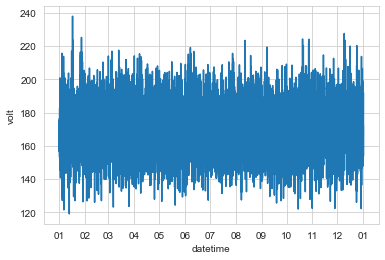

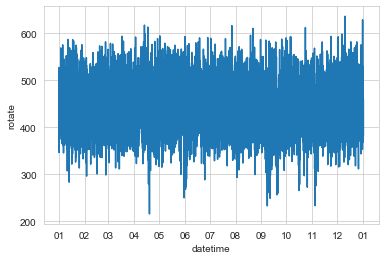

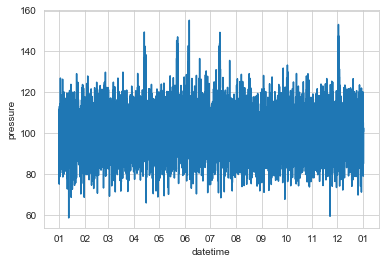

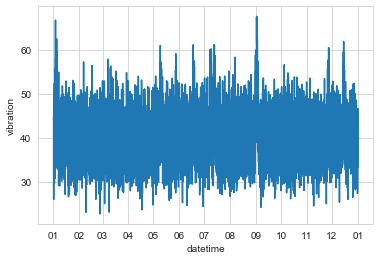

In [14]:
multiple_plots_ts(telemetry[telemetry.machineID == 1],
                  ['volt', 'rotate', 'pressure', 'vibration'],
                  'datetime')

###### **Machine ID = 2**

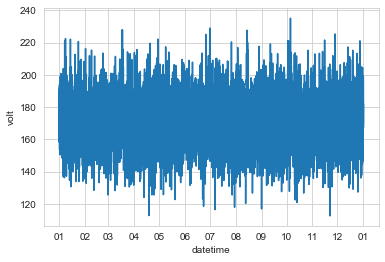

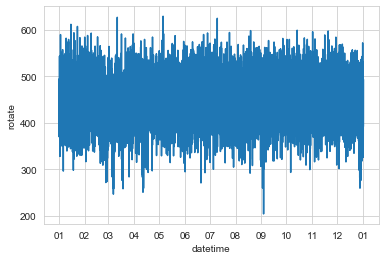

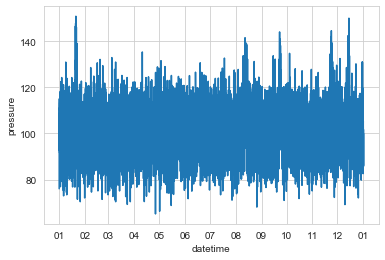

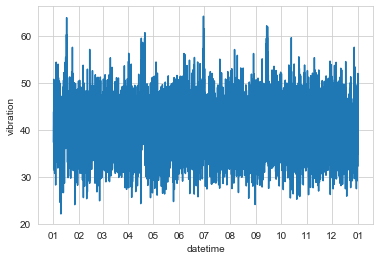

In [15]:
multiple_plots_ts(telemetry[telemetry.machineID == 2],
                  ['volt', 'rotate', 'pressure', 'vibration'],
                  'datetime')

##### Histograms

In [16]:
def hist_plots(data, numeric,col_no):
    data_fig = pd.melt(data, value_vars= numeric)
    fig = sns.FacetGrid(data_fig, col = "variable", col_wrap = col_no,sharex= False, sharey = False)
    fig = fig.map(sns.distplot, "value", color = 'c')
    return fig
#col_no : number of columns to display in one row
#numeric : name of numeric cols

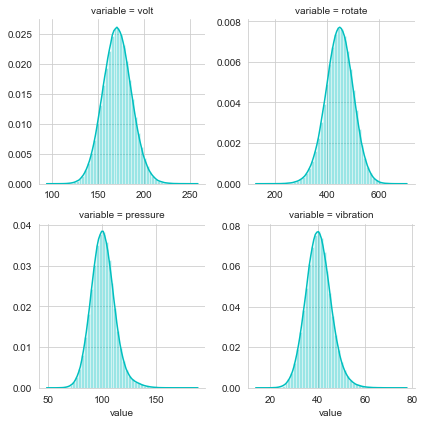

In [17]:
hist_plots(telemetry,
          ['volt', 'rotate', 'pressure', 'vibration'],2)

Thus, we see a normal distribution of telemetry variables with evident similarities between different machines.

### Machines data

#### Data import

In [18]:
machines = pd.read_csv('datasets/machine_predictive_maintenance/machines.csv')

#### Data discovery

In [19]:
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
machineID    100 non-null int64
model        100 non-null object
age          100 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.0+ KB


In [20]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [21]:
machines.machineID = machines.machineID.astype('category')
machines.model = machines.model.astype('category')

##### Total machines in every model

In [22]:
machines.model.value_counts()

model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

#### Data visualization

##### Age & models of all the machines

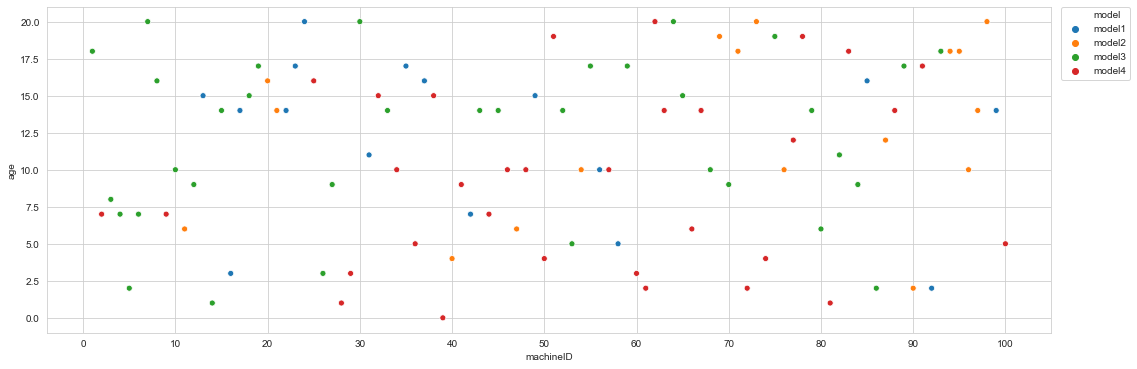

In [23]:
fig,(ax) = plt.subplots(1, 1, figsize=(18, 6))
sns.scatterplot(x = 'machineID', y = 'age', hue = 'model',data = machines)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

#increasing number of ticks on x axis
ax.xaxis.set_major_locator(plt.MaxNLocator(11))

This file has meta data of age and model type relating to the machines.

### Errors data

#### Data import

In [24]:
errors = pd.read_csv('datasets/machine_predictive_maintenance/errors.csv')

#### Data discovery

In [25]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 61.3+ KB


In [26]:
errors.head()

,datetime,machineID,errorID
0,1/3/2015 7:00:00 AM,1,error1
1,1/3/2015 8:00:00 PM,1,error3
2,1/4/2015 6:00:00 AM,1,error5
3,1/10/2015 3:00:00 PM,1,error4
4,1/22/2015 10:00:00 AM,1,error4


In [27]:
errors.datetime = pd.to_datetime(errors.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [28]:
errors.machineID = errors.machineID.astype('category')
errors.errorID = errors.errorID.astype('category')

In [29]:
errors.errorID.value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

This dataset as errors with date time and machine ID. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

### Failures data

#### Data import

In [30]:
failures = pd.read_csv('datasets/machine_predictive_maintenance/failures.csv')

#### Data discovery

In [31]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 2 columns):
datetime     719 non-null object
machineID    719 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.5+ KB


In [32]:
failures.head()

,datetime,machineID
0,1/5/2015 6:00:00 AM,1
1,3/6/2015 6:00:00 AM,1
2,4/20/2015 6:00:00 AM,1
3,6/19/2015 6:00:00 AM,1
4,9/2/2015 6:00:00 AM,1


In [33]:
failures.datetime = pd.to_datetime(failures.datetime, format = ("%m/%d/%Y %I:%M:%S %p"))

In [34]:
failures.machineID = failures.machineID.astype('category')

#### Data visualization

##### Total failures in every machine 

Text(0.5, 1.01, 'Failures per machine ID')

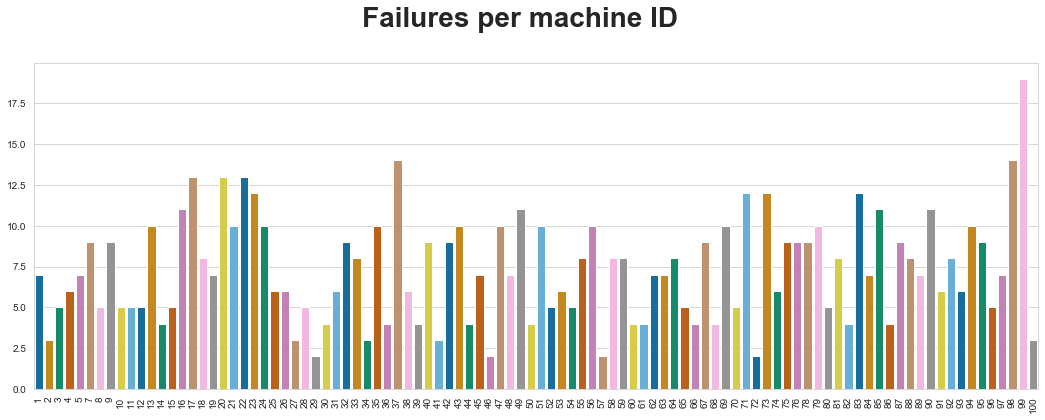

In [35]:
fig, (ax) = plt.subplots(1, 1, figsize=(18, 6))

sns.barplot(x = np.array(failures.machineID.value_counts().index),
            y = np.array(failures.machineID.value_counts()),
           palette="colorblind")

plt.xticks(rotation='vertical')

plt.suptitle('Failures per machine ID',
            y = 1.01,
            fontsize = 28,
            fontweight = 'bold')

## Feature engineering

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In this notebook, we want to calculate rolling mean and standard deviation of the telemetry data over the last 24 hour lag window, calculated for every 3 hours.

Similar to telemetry, errors also come with time-stamps. However, unlike telemetry that had numerical values, errors have categorical values denoting the type of error that occured at a time-stamp. In this case, aggregating methods such as averaging does not apply. Counting the different categories is a more viable approach where lagging counts of different types of errors that occured in the lag window are calculated. 

The machine features are used directly as they hold descriptive information about the type of the machines and their ages which is the years in service.

When using classification for predicting failure due to a problem, labeling is done by taking a time window prior to the failure of an asset and labeling the feature records that fall into that window as about to fail due to a problem while labeling all other records as normal. This time window should be picked according to the business case where in some situations it may be enough to predict failures hours in advance while in others days or weeks maybe needed to allow for the arrival of parts to be replaced as an example.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a component failure. 

Labelling is done by labeling all the feature records that fall into the 24 hours window before a failure as TRUE.The rest of the records are labeled as FALSE indicating, there is no failure within the next 24 hour

*The above described data formatting and feature engineering is not the part of notebook as it will deviate us from our goal. I have directly imported the file after the above said transformations are completed.*

In [36]:
df = pd.read_csv('datasets/machine_predictive_maintenance/features.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291300 entries, 0 to 291299
Data columns (total 18 columns):
datetime         291300 non-null object
machineID        291300 non-null int64
voltmean         291300 non-null float64
rotatemean       291300 non-null float64
pressuremean     291300 non-null float64
vibrationmean    291300 non-null float64
voltsd           291300 non-null float64
rotatesd         291300 non-null float64
pressuresd       291300 non-null float64
vibrationsd      291300 non-null float64
error1count      291300 non-null float64
error2count      291300 non-null float64
error3count      291300 non-null float64
error4count      291300 non-null float64
error5count      291300 non-null float64
model            291300 non-null object
age              291300 non-null int64
failure          291300 non-null bool
dtypes: bool(1), float64(13), int64(2), object(2)
memory usage: 35.8+ MB


In [38]:
df.head()

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
0,2015-01-02T05:00:00Z,1,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,model3,18,False
1,2015-01-02T08:00:00Z,1,170.525721,443.906847,97.667249,39.786670,12.591948,46.930282,9.406795,6.098173,0.0,0.0,0.0,0.0,0.0,model3,18,False
2,2015-01-02T11:00:00Z,1,170.049722,446.461279,96.906162,40.016513,13.277336,42.836780,9.071472,5.481724,0.0,0.0,0.0,0.0,0.0,model3,18,False
3,2015-01-02T14:00:00Z,1,170.341974,447.355315,96.229522,39.921963,13.817158,42.808633,8.256794,5.862312,0.0,0.0,0.0,0.0,0.0,model3,18,False
4,2015-01-02T17:00:00Z,1,170.060643,452.163407,96.357441,39.990470,14.792869,42.525293,8.669605,5.907157,0.0,0.0,0.0,0.0,0.0,model3,18,False


#### Ensuring type consistency

In [39]:
df.datetime = pd.to_datetime(df.datetime)

In [40]:
df.model = df.model.astype('category')

#### Total failures 

In [41]:
df.failure.value_counts()

False    285705
True       5595
Name: failure, dtype: int64

## Model Development

### Pre processing of data

#### Training and testing set

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['failure','datetime'],axis = 1), 
                                                    df.failure,
                                                    test_size=0.3,
                                                    train_size = 0.7,
                                                    random_state=101)

In [43]:
len(y_test)

87390

In [44]:
y_test.value_counts()

False    85691
True      1699
Name: failure, dtype: int64

In [45]:
len(y_train)

203910

In [46]:
y_train.value_counts()

False    200014
True       3896
Name: failure, dtype: int64

#### Dealing with numeric and categorical variables 

Typically, numeric variables are scaled to avoid over-fitting on anomalies and maintaining a generalized model development. However, in this notebook our aim to interpret model developed so we would not scale our features. <br> Model is a categorical feature and we will use one hot encoding to tackle it as it has only four unique classes.

In [47]:
numeric = list(X_train.select_dtypes(include=['float64','int64']).columns)

num = pd.DataFrame(data = X_train[numeric], columns = numeric)
num.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,age
223994,77,186.716299,443.699369,98.619249,38.858736,17.353674,44.645681,12.467771,4.652137,0.0,0.0,0.0,0.0,0.0,12
285560,99,169.526588,455.163821,101.596673,39.858468,14.826978,53.594743,9.655152,4.591573,0.0,0.0,0.0,0.0,0.0,14
184307,64,167.921308,434.531181,98.966585,39.219417,19.364052,48.913727,9.476126,6.021723,0.0,0.0,0.0,0.0,0.0,20
112749,39,166.642070,458.970319,97.653249,39.817805,13.919433,52.055430,10.820214,5.040097,0.0,0.0,0.0,0.0,0.0,0
58042,20,167.570358,457.004586,100.985528,40.284269,16.178388,56.404641,11.056968,4.299149,0.0,0.0,0.0,0.0,0.0,16


In [48]:
categorical = list(X_train.select_dtypes(include=['category','bool']).columns)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(X_train[categorical])
cat = pd.DataFrame(encoder.transform(X_train[categorical]).toarray(),columns = encoder.get_feature_names())

cat.index = num.index #ensuring consistent index for join operation

cat.head()

,x0_model1,x0_model2,x0_model3,x0_model4
223994,0.0,0.0,0.0,1.0
285560,1.0,0.0,0.0,0.0
184307,0.0,0.0,1.0,0.0
112749,0.0,0.0,0.0,1.0
58042,0.0,1.0,0.0,0.0


In [49]:
X_train_pre = num.merge(cat, left_on=num.index, right_on= cat.index).drop(['key_0'],axis = 1)

In [50]:
X_train_pre.shape

(203910, 19)

In [51]:
num = pd.DataFrame(data = X_test[numeric], columns = numeric)
cat = pd.DataFrame(encoder.transform(X_test[categorical]).toarray(),columns = encoder.get_feature_names())
cat.index = num.index #ensuring consistent index for join operation
X_test_pre = num.merge(cat, left_on=num.index, right_on= cat.index).drop(['key_0'],axis = 1)
X_test_pre.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,age,x0_model1,x0_model2,x0_model3,x0_model4
0,15,170.058262,450.955638,100.331765,38.186484,10.969578,52.123556,9.749602,4.720366,0.0,0.0,1.0,1.0,0.0,14,0.0,0.0,1.0,0.0
1,16,168.358077,449.561659,95.777900,38.495238,19.430792,54.485817,9.376011,4.111367,0.0,0.0,0.0,0.0,0.0,3,1.0,0.0,0.0,0.0
2,98,170.754426,465.972087,100.008176,40.186561,13.744661,57.646367,11.935712,4.476155,0.0,0.0,0.0,0.0,0.0,20,0.0,1.0,0.0,0.0
3,28,168.159750,452.247367,100.590732,40.407637,15.660684,49.489116,9.266770,4.614694,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0
4,83,171.372509,446.990435,99.944631,40.452216,14.119965,58.887861,7.150367,4.684244,0.0,0.0,0.0,0.0,0.0,18,0.0,0.0,0.0,1.0


### XGBoost algorithm

In [52]:
import xgboost as xgb

In [53]:
%%time

xgb_clf =xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=101)

xgb_clf.fit(X_train_pre,y_train)

Wall time: 3min 20s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Out of sample predictions

In [54]:
y_pred = xgb_clf.predict(X_test_pre)

#### Confusion Matrix

In [55]:
df_demo = {'y_Predicted': list((y_pred > 0.5)),
        'y_Actual':    list(y_test) }
df_cm = pd.DataFrame(df_demo, columns=['y_Actual','y_Predicted'])
pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,85667,24
True,3,1696


#### Model accuracy

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, (y_pred > 0.5))

0.9996910401647786

#### Classification report

In [57]:
from sklearn.metrics import classification_report

target_names = ['True', 'False']
print(classification_report(y_test.values, (y_pred > 0.5), 
                            target_names=target_names))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00     85691
       False       0.99      1.00      0.99      1699

    accuracy                           1.00     87390
   macro avg       0.99      1.00      1.00     87390
weighted avg       1.00      1.00      1.00     87390



## Interpretation of model

### Feature importance through sklearn 

In [58]:
feature_importances = pd.DataFrame(xgb_clf.feature_importances_,
                                   index = X_train_pre.columns,
                                    columns=['importance']).sort_values('importance', 
                                                                        ascending=False)
feature_importances

,importance
error2count,0.334370
error3count,0.231356
error5count,0.118583
error1count,0.084275
voltmean,0.053869
pressuremean,0.046154
error4count,0.045168
vibrationmean,0.036023
x0_model4,0.015143
rotatemean,0.009705


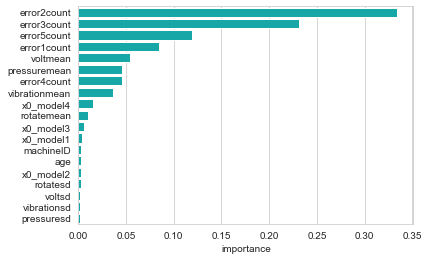

In [59]:
sns.barplot(x='importance', y=feature_importances.index, 
            data=feature_importances, color="c")

### Feature importance through XGBoost

The model enables us to view feature importances based on the following.

- Feature Weights: This is based on the number of times a feature appears in a tree across the ensemble of trees
- Gain: This is based on the average gain of splits which use the feature
- Coverage: This is based on the average coverage (number of samples affected) of splits which use the feature

Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).

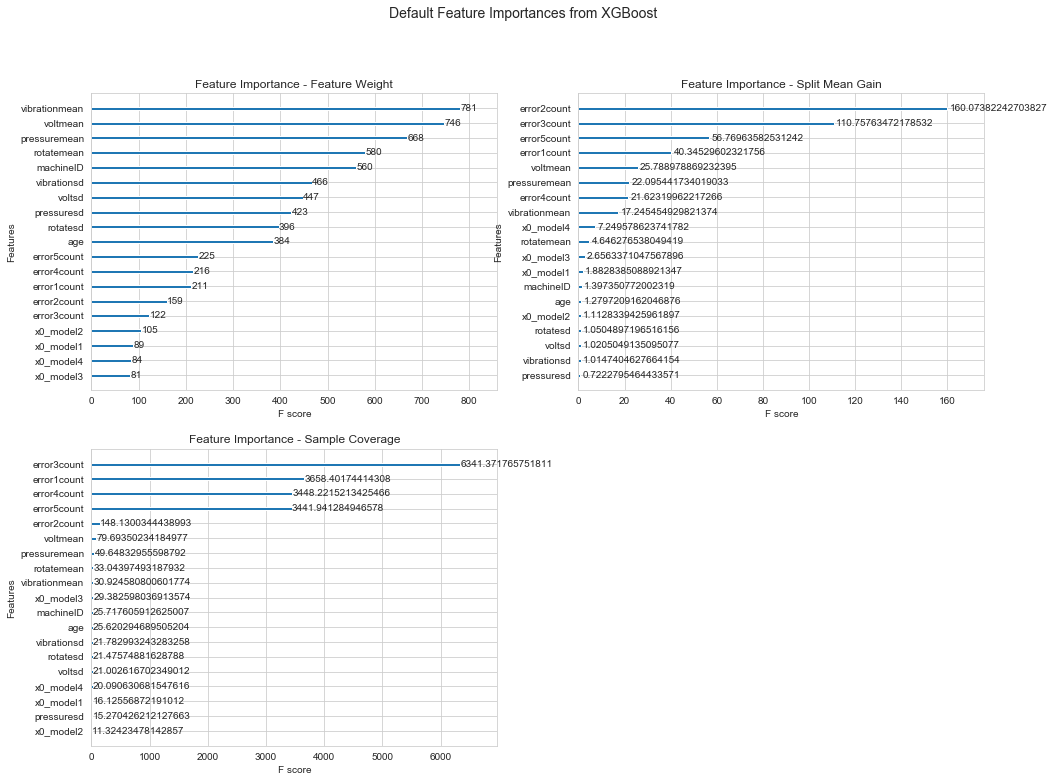

In [60]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgb_clf, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgb_clf, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgb_clf, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

## Feature importance through ELI5

[ELI5](https://eli5.readthedocs.io/en/latest/) is a Python package which helps to debug machine learning classifiers and explain their predictions. ELI5 has supports two main ways for interpretation as follows:

1. inspect model parameters and try to figure out how the model works globally;
2. inspect an individual prediction of a model, try to figure out why the model makes the decision it makes.


In [61]:
import eli5

#### Global feature importance

Typically for tree-based models ELI5 does nothing special but uses the out-of-the-box feature importance computation methods which we discussed in the previous section. By default, **'gain'** is used, that is the average gain of the feature when it is used in trees.

In [62]:
eli5.show_weights(xgb_clf.get_booster())

Weight,Feature
0.3344,error2count
0.2314,error3count
0.1186,error5count
0.0843,error1count
0.0539,voltmean
0.0462,pressuremean
0.0452,error4count
0.0360,vibrationmean
0.0151,x0_model4
0.0097,rotatemean


#### Explaining model predictions locally

Weight means how much each feature contributed to the final prediction across all trees. The idea for weight calculation is described in http://blog.datadive.net/interpreting-random-forests/; eli5 provides an independent implementation of this algorithm for XGBoost and most scikit-learn tree ensembles.

In [63]:
row_no = 0
print('Actual Label:', y_test.iloc[row_no])
print('Predicted Label:', y_pred[row_no])
eli5.show_prediction(xgb_clf.get_booster(), X_test_pre.iloc[row_no], 
                     feature_names=list(X_train_pre.columns) ,show_feature_values=True)

Actual Label: False
Predicted Label: False


In [64]:
#searching for index of first true value
for i in range(0,len(y_test)):
    if(y_test.iloc[i] == True):
        x = i
        break

row_no = x
print('Actual Label:', y_test.iloc[row_no])
print('Predicted Label:', y_pred[row_no])
eli5.show_prediction(xgb_clf.get_booster(), X_test_pre.iloc[row_no], 
                     feature_names=list(X_train_pre.columns) ,show_feature_values=True)

Actual Label: True
Predicted Label: True


### Feature importance through SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods  and representing the only possible consistent and locally accurate additive feature attribution method based on expectations. Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models. <br>
SHAP assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach.

![Approach of SHAP](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png)

In [65]:
import shap

# load JS visualization code to notebook
shap.initjs()

#### Explain predictions with SHAP

In [66]:
%%time

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_pre)

Wall time: 2min 30s


In [67]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.329522,-2.722088,-0.953962,-2.268384,0.035187,0.746256,0.225530,0.241734,0.227004,-1.719183,-0.678468,3.103551,3.008043,-0.568464,0.135238,-0.204715,-0.357696,-0.524014,0.141733
1,-0.197200,-2.940614,0.063404,-1.000828,-0.237157,-1.048602,0.140688,-0.010864,0.095075,-2.380255,-0.216144,-0.145914,-1.253128,-0.757833,-0.007309,0.290818,0.023468,-0.011363,0.047729
2,0.927377,-3.566819,-0.428218,-1.177582,-0.057940,0.105760,-0.152119,-0.036100,0.652694,-2.582935,-0.207945,-0.142308,-1.214113,-0.714510,0.573620,0.003712,-0.003232,-0.024020,0.072956
3,0.038294,-3.220149,-0.125595,-1.245862,-0.413336,0.256015,-0.107120,0.049309,0.301586,-2.475740,-0.220070,-0.148733,-1.010508,-0.747643,0.278663,-0.080938,-0.091248,-0.063890,-0.435201
4,-0.209414,-3.319834,-0.469547,-0.885241,-0.663134,-0.183006,-0.288973,0.252362,0.518381,-2.487559,-0.220402,-0.149047,-0.899229,-0.744103,-0.274317,-0.016503,-0.058380,-0.088716,-0.243205


This returns a matrix of SHAP values (# samples x # features). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

##### Predicting when machine does fail

SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting when machine would fail. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [68]:
y_test.iloc[x]

True

In [69]:
shap.force_plot(explainer.expected_value, shap_values[x,:], X_test_pre.iloc[x,:])

##### Predicting when machine does not fail

In [70]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_pre.iloc[0,:])

#### Visualizating and explaining multiple predictions

In [71]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_pre.iloc[:1000,:])

#### Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

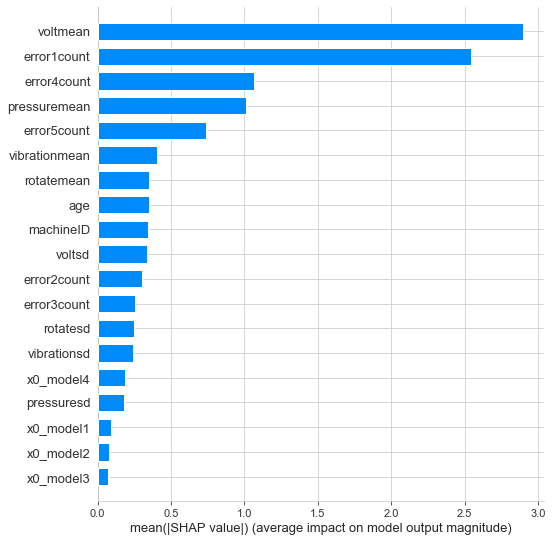

In [72]:
shap.summary_plot(shap_values, X_test_pre, plot_type="bar")

#### SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

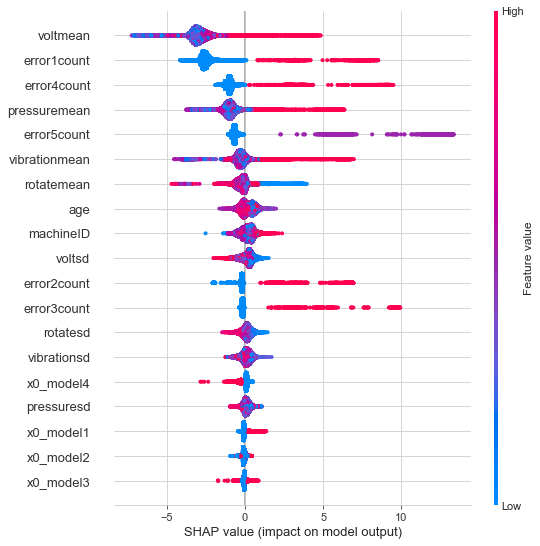

In [73]:
shap.summary_plot(shap_values, X_test_pre)

#### SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

##### PDP of 'voltmean' affecting model prediction

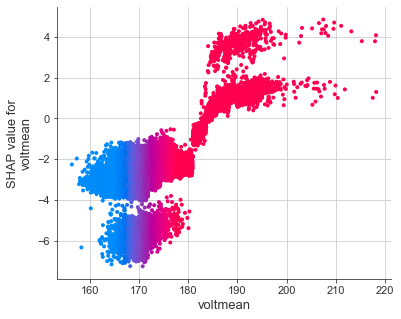

In [74]:
shap.dependence_plot(ind='voltmean', interaction_index='voltmean',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### PDP of 'error1count' affecting model prediction

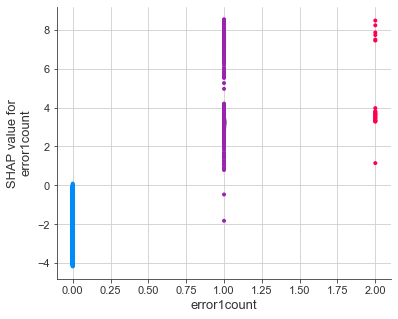

In [75]:
shap.dependence_plot(ind='error1count', interaction_index='error1count',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### PDP of 'pressuremean' affecting model prediction

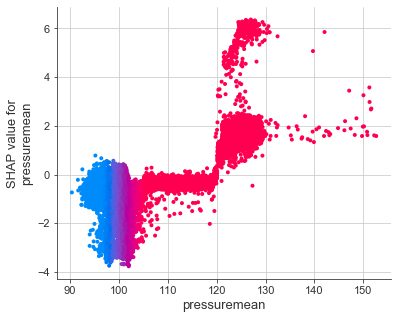

In [76]:
shap.dependence_plot(ind='pressuremean', interaction_index='pressuremean',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### PDP of 'vibrationmean' affecting model prediction

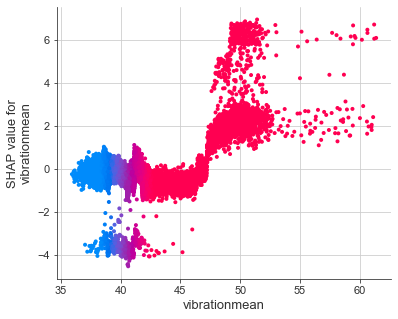

In [77]:
shap.dependence_plot(ind='vibrationmean', interaction_index='vibrationmean',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### PDP of 'rotatemean' affecting model prediction

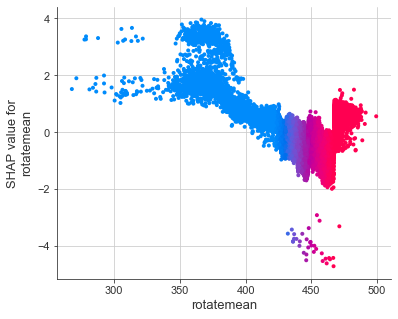

In [78]:
shap.dependence_plot(ind='rotatemean', interaction_index='rotatemean',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### Two-way PDP showing interactions between features 'voltmean' and 'pressuremean'

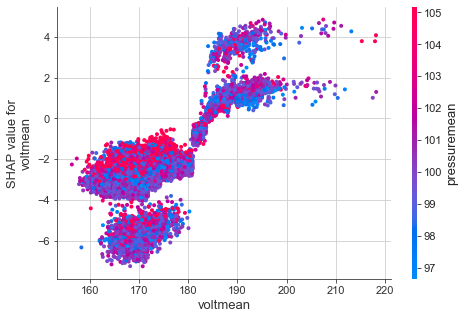

In [79]:
shap.dependence_plot(ind='voltmean', interaction_index='pressuremean',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)

##### Two-way PDP showing interactions between features 'voltmean' and 'error1count'

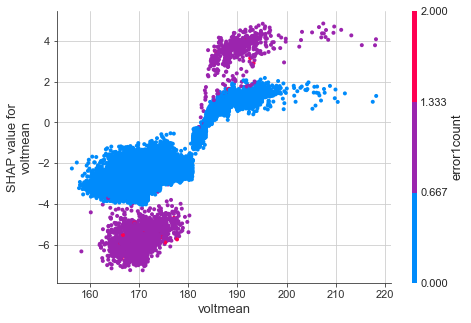

In [80]:
shap.dependence_plot(ind='voltmean', interaction_index='error1count',
                     shap_values=shap_values, 
                     features=X_test_pre,  
                     display_features=X_test_pre)